In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

# 1: PREDICING NUMBER OF SHOOTING INCIDENTS WITH LINEAR REGRESSION #

## *USING STANDARD DEVIATION TO NORMALIZE VALUES* ##

In [2]:
reps = pd.read_csv("representatives_MASTER.csv")
vio = pd.read_csv("violence_census_MASTER.csv")

In [3]:
vio["capita"] = vio["count_of_inc"] / (vio["pop_votingage_est"] / 100000)
vio["capitaSTD"] = (vio["capita"] - vio["capita"].mean()) / vio["capita"].std()

In [4]:
# REMOVE ALL ENTRIES FOR TERMS OTHER THAN 114 (2015-2017)
reps.drop(reps[reps["term"] != 114].index, inplace=True)

In [5]:
combo = reps.merge(vio, on="area_id")

# REMOVE OUTLIERS > 2 STANDARD DEVIATION
comboNO = combo.drop(combo[combo["capitaSTD"] > 2].index)

In [6]:
columns = ['edu_ltgrade9_perc', 'edu_9to12_perc', 'edu_hs_perc', 'edu_somecollege_perc', 'edu_bachelor_perc', 
    'edu_graduate_perc', 'edu_hsormore_perc', 'edu_bachormore_perc', 'poverty_perc', 'pop_votingrate_perc']

for item in columns:
    comboNO["std_"+item] = (comboNO[item] - comboNO[item].mean()) / comboNO[item].std()

# REMOVE OUTLIERS > 2 STANDARD DEVIATION
for outlier in columns:
    comboNO.drop(comboNO[comboNO["std_"+outlier] > 2].index, inplace=True )

comboNO = comboNO.join(pd.get_dummies(comboNO["group"]))

In [7]:
linreg = LinearRegression()

In [8]:
indepArray = comboNO[['std_edu_ltgrade9_perc', 'std_edu_9to12_perc', 'std_edu_hs_perc', 'std_edu_somecollege_perc', 'std_edu_bachelor_perc', 'std_edu_graduate_perc',
    'std_edu_hsormore_perc', 'std_edu_bachormore_perc', 'std_poverty_perc', 'std_pop_votingrate_perc', 'Democrat', 'Republican']]
depArray = comboNO["capitaSTD"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(indepArray, depArray, test_size=0.5)
linreg.fit(X_train, y_train)
linreg.score(X_test, y_test)

0.3403010117450609

In [10]:
coeff_df = pd.DataFrame(linreg.coef_, indepArray.columns, columns=["Coefficient"])
coeff_df.Coefficient.sort_values()

std_edu_bachormore_perc    -1.577175
std_edu_hsormore_perc      -1.050480
std_edu_ltgrade9_perc      -0.533149
std_edu_9to12_perc         -0.466476
Republican                 -0.169488
std_pop_votingrate_perc     0.016603
std_edu_somecollege_perc    0.116402
Democrat                    0.169488
std_poverty_perc            0.353976
std_edu_hs_perc             0.369488
std_edu_graduate_perc       1.020335
std_edu_bachelor_perc       1.251499
Name: Coefficient, dtype: float64

# 2: CLASSIFYING DANGEROUS DISTRICTS WITH KNN #

In [11]:
reps = pd.read_csv("representatives_MASTER.csv")
vio = pd.read_csv("violence_census_MASTER.csv")

In [12]:
vio["capita"] = vio["count_of_inc"] / (vio["pop_votingage_est"] / 100000)
vio["capitaSTD"] = (vio["capita"] - vio["capita"].mean()) / vio["capita"].std()

In [13]:
# REMOVE ALL ENTRIES FOR TERMS OTHER THAN 114 (2015-2017)
reps.drop(reps[reps["term"] != 114].index, inplace=True)

In [14]:
combo = reps.merge(vio, on="area_id")

# REMOVE OUTLIERS > 3 STANDARD DEVIATION
comboNO = combo.drop(combo[combo["capitaSTD"] > 3].index)

In [15]:
discret = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform")

In [16]:
columns = ['edu_ltgrade9_perc', 'edu_9to12_perc', 'edu_hs_perc', 'edu_somecollege_perc', 'edu_bachelor_perc', 'edu_graduate_perc', 
    'edu_hsormore_perc','edu_bachormore_perc', 'poverty_perc', 'pop_votingrate_perc']

for item in columns:
    comboNO["std_"+item] = (comboNO[item] - comboNO[item].mean()) / comboNO[item].std()

comboNO = comboNO.join(pd.get_dummies(comboNO["group"]))

# REMOVE OUTLIERS > 3 STANDARD DEVIATION
for outlier in columns:
    comboNO.drop(comboNO[comboNO["std_"+outlier] > 3].index, inplace=True )

In [17]:
columns = ['edu_ltgrade9_perc', 'edu_9to12_perc', 'edu_hs_perc', 'edu_somecollege_perc',
    'edu_bachelor_perc', 'edu_graduate_perc', 'edu_hsormore_perc',
    'edu_bachormore_perc', 'poverty_perc', 'pop_votingrate_perc', "capitaSTD"]

for bin_cat in columns:
    comboNO["bin_"+bin_cat] = discret.fit_transform(comboNO[[bin_cat]])      

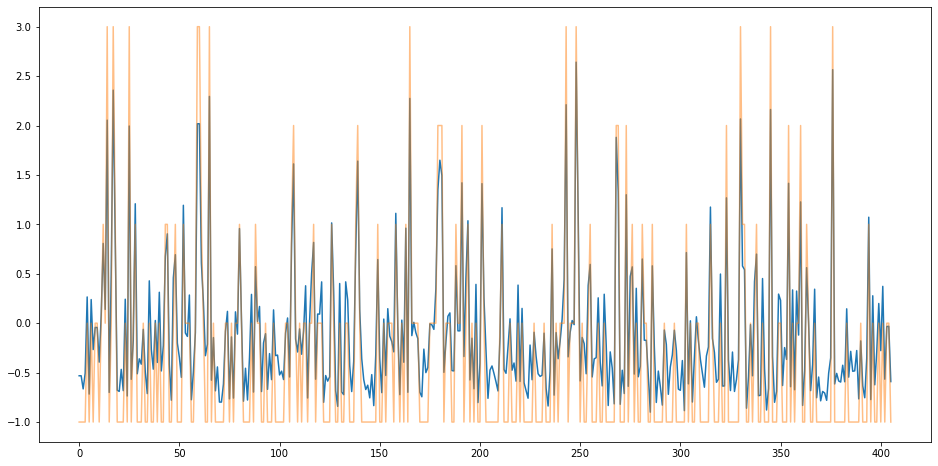

In [18]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(comboNO["bin_capitaSTD"].count()), comboNO["capitaSTD"])
plt.plot(np.arange(comboNO["bin_capitaSTD"].count()), comboNO["bin_capitaSTD"]-1, alpha=0.5)

In [19]:
binned_columns = ['bin_edu_ltgrade9_perc', 'bin_edu_9to12_perc', 'bin_edu_hs_perc', 'bin_edu_somecollege_perc', 
    'bin_edu_bachelor_perc', 'bin_edu_graduate_perc', 'bin_edu_hsormore_perc', 'bin_edu_bachormore_perc', 
    'bin_poverty_perc', 'bin_pop_votingrate_perc']

for column in binned_columns:
    comboNO = comboNO.join(pd.get_dummies(comboNO[column], prefix=column))

In [20]:
knn = KNeighborsClassifier(n_neighbors=15, weights="distance")

In [21]:
indepArray = comboNO[['Democrat', 'Republican', 'bin_edu_ltgrade9_perc', 'bin_edu_9to12_perc', 'bin_edu_hs_perc',
    'bin_edu_somecollege_perc', 'bin_edu_bachelor_perc', 'bin_edu_graduate_perc', 'bin_edu_hsormore_perc',
    'bin_edu_bachormore_perc', 'bin_poverty_perc', 'bin_pop_votingrate_perc', 'bin_edu_ltgrade9_perc_0.0',
    'bin_edu_ltgrade9_perc_1.0', 'bin_edu_ltgrade9_perc_2.0', 'bin_edu_ltgrade9_perc_3.0', 'bin_edu_ltgrade9_perc_4.0', 
    'bin_edu_9to12_perc_0.0', 'bin_edu_9to12_perc_1.0', 'bin_edu_9to12_perc_2.0', 'bin_edu_9to12_perc_3.0',
    'bin_edu_9to12_perc_4.0', 'bin_edu_hs_perc_0.0', 'bin_edu_hs_perc_1.0', 'bin_edu_hs_perc_2.0', 'bin_edu_hs_perc_3.0', 
    'bin_edu_hs_perc_4.0', 'bin_edu_somecollege_perc_0.0', 'bin_edu_somecollege_perc_1.0', 'bin_edu_somecollege_perc_2.0',
    'bin_edu_somecollege_perc_3.0', 'bin_edu_somecollege_perc_4.0', 'bin_edu_bachelor_perc_0.0', 'bin_edu_bachelor_perc_1.0',
    'bin_edu_bachelor_perc_2.0', 'bin_edu_bachelor_perc_3.0', 'bin_edu_bachelor_perc_4.0', 'bin_edu_graduate_perc_0.0',
    'bin_edu_graduate_perc_1.0', 'bin_edu_graduate_perc_2.0', 'bin_edu_graduate_perc_3.0', 'bin_edu_graduate_perc_4.0',
    'bin_edu_hsormore_perc_0.0', 'bin_edu_hsormore_perc_1.0', 'bin_edu_hsormore_perc_2.0', 'bin_edu_hsormore_perc_3.0',
    'bin_edu_hsormore_perc_4.0', 'bin_edu_bachormore_perc_0.0', 'bin_edu_bachormore_perc_1.0', 'bin_edu_bachormore_perc_2.0',
    'bin_edu_bachormore_perc_3.0', 'bin_edu_bachormore_perc_4.0', 'bin_poverty_perc_0.0', 'bin_poverty_perc_1.0',
    'bin_poverty_perc_2.0', 'bin_poverty_perc_3.0', 'bin_poverty_perc_4.0', 'bin_pop_votingrate_perc_0.0',
    'bin_pop_votingrate_perc_2.0', 'bin_pop_votingrate_perc_3.0', 'bin_pop_votingrate_perc_4.0']]
depArray = comboNO["bin_capitaSTD"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(indepArray, depArray, test_size=0.5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.5862068965517241

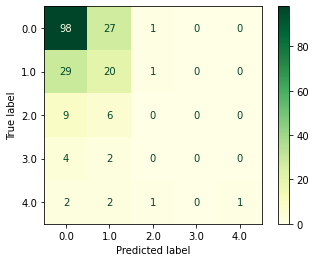

In [23]:
pred = knn.predict(X_test)
plot_confusion_matrix(knn, X_test, y_test, cmap="YlGn")
plt.show()